In [2]:
import json

In [3]:
filename = 'demo1.txt'

In [4]:
header_order = {}
answer_count = 0

In [5]:
with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                record = json.loads(line)
                if "answer" in record:
                    answer_count += 1
                    for key in record["answer"].keys():
                        if key not in header_order:
                            header_order[key] = None
            except Exception as e:
                print(f"Error parsing line: {e}")


In [6]:
print(f"Number of 'answer' entries in the file: {answer_count}")

Number of 'answer' entries in the file: 36


In [7]:
print("Headers found in 'answer' (in file order):")
for h in header_order:
    print(h)

Headers found in 'answer' (in file order):
datenow
timenow
rangeIdx
dopplerIdx
numDetectedObj
x_coord
y_coord
z_coord
rp_y
doppz
interFrameProcessingTime
interFrameProcessingMargin
interChirpProcessingMargin
transmitOutputTime
activeFrameCPULoad
interFrameCPULoad
snrDB
noiseDB
activity


In [8]:
from collections import defaultdict

# We'll group results in this dictionary
# Structure: { timenow_value : [ {'rp_y': ..., 'doppz': ...}, ... ] }
grouped_by_time = defaultdict(list)

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                record = json.loads(line)
                if "answer" in record:
                    ans = record["answer"]
                    time_val = ans.get("timenow", None)
                    rp_y_val = ans.get("rp_y", None)
                    doppz_val = ans.get("doppz", None)
                    if time_val is not None:
                        grouped_by_time[time_val].append({
                            "rp_y": rp_y_val,
                            "doppz": doppz_val
                        })
            except Exception as e:
                print(f"Error parsing line: {e}")

# Example: print all groups (only first 2 entries for each time to keep output short)
for t, values in grouped_by_time.items():
    print(f"timenow: {t}, entries: {len(values)}")
    for v in values[:2]:  # Show first two
        print("  rp_y:", v["rp_y"])
        print("  doppz:", v["doppz"])
    print()


timenow: 20_1_38, entries: 2
  rp_y: [92.87245725602045, 101.6681774418274, 102.93814773603482, 97.99937436967264, 89.6034596468569, 82.31288943936985, 76.36284343132398, 73.63475909561915, 70.22465367598811, 83.84155738610102, 90.54417838330684, 89.39179793115566, 84.87634799619595, 89.36827996274442, 100.49227902126498, 103.50257897790479, 100.63338683173247, 100.39820714761998, 105.54864222968341, 104.86662114575721, 94.6363048868641, 98.04641030649513, 97.62308687509265, 96.35311658088523, 90.21492682554937, 79.2790715143188, 81.16050898721868, 79.84350275618877, 76.9037567047827, 75.58675047375277, 71.72980365430801, 74.17567236907787, 71.80035755954177, 72.71755832758046, 73.56420519038541, 74.55195986365784, 74.90472938982657, 72.29423489617798, 69.96595602346439, 71.54165990701803, 70.4598333601006, 69.47207868682816, 68.36673417149947, 69.84836618140814, 69.47207868682816, 69.75429430776315, 70.31872554963311, 68.34321620308823, 69.23689900271567, 74.05808252702163, 75.5397145

In [4]:
import matplotlib.pyplot as plt

# Ensure the number of time steps
all_times = list(grouped_by_time.keys())
all_times_sorted = sorted(all_times)  # Sort for better visualization, remove if you want original order

for idx, t in enumerate(all_times_sorted):
    plt.figure(figsize=(6, 3))
    rp_y_list = [entry["rp_y"] for entry in grouped_by_time[t] if entry["rp_y"] is not None]
    # If there are multiple entries for the same timenow, plot each as a line (otherwise, one line)
    for i, rp_y in enumerate(rp_y_list):
        plt.plot(rp_y, label=f'Entry {i+1}')
    plt.title(f"rp_y at timenow: {t}")
    plt.xlabel("Index")
    plt.ylabel("rp_y (Power Profile)")
    plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"rpy_time_{t}.png")
    plt.close()



In [9]:
from matplotlib.animation import FuncAnimation

# Sort timenow values for smooth animation
all_times_sorted = sorted(grouped_by_time.keys())

# Create a list of rp_y arrays (take the first rp_y for each timenow if there are multiple)
rp_y_frames = []
for t in all_times_sorted:
    rp_y_list = [entry["rp_y"] for entry in grouped_by_time[t] if entry["rp_y"] is not None]
    if rp_y_list:
        rp_y_frames.append(rp_y_list[0])  # Use first entry per time, or adjust if you want to aggregate

n_frames = len(rp_y_frames)
max_length = max(len(rp) for rp in rp_y_frames)
min_val = min(min(rp) for rp in rp_y_frames)
max_val = max(max(rp) for rp in rp_y_frames)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7080\2382920803.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


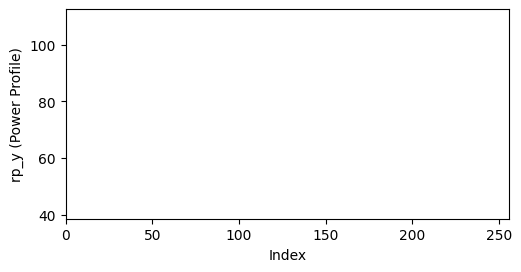

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, max_length)
ax.set_ylim(min_val, max_val)
ax.set_xlabel("Index")
ax.set_ylabel("rp_y (Power Profile)")
title = ax.set_title("")

def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

def animate(i):
    y = rp_y_frames[i]
    x = list(range(len(y)))
    line.set_data(x, y)
    title.set_text(f"rp_y at timenow: {all_times_sorted[i]}")
    return line, title

ani = FuncAnimation(fig, animate, frames=n_frames, init_func=init,
                    interval=500, blit=True, repeat=True)

plt.tight_layout()
plt.show()


In [14]:
#Extracted 36 frames of rp_y and 36 frames of doppz.
all_rp_y = []
all_doppz = []

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                record = json.loads(line)
                if "answer" in record:
                    ans = record["answer"]
                    # Append rp_y (power profile)
                    all_rp_y.append(ans.get("rp_y", []))
                    # Append doppz (doppler profile)
                    all_doppz.append(ans.get("doppz", []))
            except Exception as e:
                print(f"Error parsing line: {e}")

In [15]:
# Print rp_y values for the first 36 frames
for i in range(36):
    print(f"Frame {i}:")
    print(all_rp_y[i])
    print('-' * 40)


Frame 0:
[92.87245725602045, 101.6681774418274, 102.93814773603482, 97.99937436967264, 89.6034596468569, 82.31288943936985, 76.36284343132398, 73.63475909561915, 70.22465367598811, 83.84155738610102, 90.54417838330684, 89.39179793115566, 84.87634799619595, 89.36827996274442, 100.49227902126498, 103.50257897790479, 100.63338683173247, 100.39820714761998, 105.54864222968341, 104.86662114575721, 94.6363048868641, 98.04641030649513, 97.62308687509265, 96.35311658088523, 90.21492682554937, 79.2790715143188, 81.16050898721868, 79.84350275618877, 76.9037567047827, 75.58675047375277, 71.72980365430801, 74.17567236907787, 71.80035755954177, 72.71755832758046, 73.56420519038541, 74.55195986365784, 74.90472938982657, 72.29423489617798, 69.96595602346439, 71.54165990701803, 70.4598333601006, 69.47207868682816, 68.36673417149947, 69.84836618140814, 69.47207868682816, 69.75429430776315, 70.31872554963311, 68.34321620308823, 69.23689900271567, 74.05808252702163, 75.53971453693028, 71.00074663355932, 

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.animation import FuncAnimation

# Create a folder to save plots (optional but recommended)
save_dir = "rp_y_plots"
os.makedirs(save_dir, exist_ok=True)

for i in range(36):
    rp_y_values = all_rp_y[i]
    n = len(rp_y_values)
    x_range = np.linspace(0, 10, n)

    plt.figure(figsize=(7, 4))
    plt.plot(x_range, rp_y_values, marker='o')
    plt.xlabel('Range')
    plt.ylabel('rp_y (received power dB)')
    plt.title(f'Frame {i} - Power Profile')
    plt.grid(True)
    plt.tight_layout()

    # Save plot as image file (e.g., PNG)
    plt.savefig(f"{save_dir}/rp_y_frame_{i:02d}.png")
    plt.close()  # Close the figure to avoid memory issues

print("All 36 plots have been saved in the 'rp_y_plots' folder.")


All 36 plots have been saved in the 'rp_y_plots' folder.


Total rp_y frames found: 36
Animation saved as rp_y_animation.gif


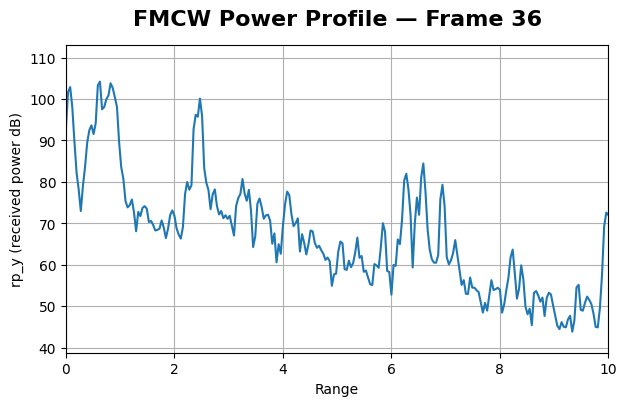

In [33]:

num_frames = len(all_rp_y)
print(f"Total rp_y frames found: {num_frames}")

# === ANIMATION ===

fig, ax = plt.subplots(figsize=(7, 4))
#line, = ax.plot([], [], marker='o')
line, = ax.plot([], [])
title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', va='bottom', fontsize=16, fontweight='bold')
frame_text = ax.text(0.95, 0.02, '', transform=ax.transAxes, ha='right', va='bottom', fontsize=14, color='red')

ax.set_xlabel('Range')
ax.set_ylabel('rp_y (received power dB)')
ax.set_xlim(0, 10)
ax.grid(True)

# Set y limits based on all rp_y data
min_y = min([min(rp_y) for rp_y in all_rp_y])
max_y = max([max(rp_y) for rp_y in all_rp_y])
ax.set_ylim(min_y, max_y)

def init():
    line.set_data([], [])
    title.set_text('')
    frame_text.set_text('')
    return line, title, frame_text

def animate(i):
    y = all_rp_y[i]
    x = np.linspace(0, 10, len(y))
    line.set_data(x, y)
    title.set_text(f"FMCW Power Profile — Frame {i+1}")
    #frame_text.set_text(f"Frame {i+1}/{num_frames}")
    return line, title, frame_text

ani = FuncAnimation(
    fig, animate, frames=num_frames, init_func=init,
    interval=400, blit=True
)

# === SAVE AS GIF ===
ani.save('rp_y_animation1.gif', writer='pillow', fps=2)
print("Animation saved as rp_y_animation.gif")

In [38]:
# 1. Convert all to NumPy arrays and filter 2D
all_doppz_np = []
for d in all_doppz:
    arr = np.array(d)
    if arr.ndim == 2:
        all_doppz_np.append(arr)

In [41]:
# Print doopz values for the first 36 frames
for i in range(36):
    print(f"Frame {i}:")
    print(all_doppz_np[i])
    print('-' * 40)

Frame 0:
[[2598 2380 2429 ... 2437 2564 2679]
 [2674 2622 2469 ... 2521 2424 2616]
 [2488 2741 2719 ... 2338 2388 2392]
 ...
 [2621 2883 2882 ... 2416 2384 2516]
 [2574 2770 2809 ... 2356 2382 2499]
 [2488 2492 2663 ... 2424 2543 2558]]
----------------------------------------
Frame 1:
[[2503 2499 2314 ... 2411 2435 2262]
 [2545 2511 2461 ... 2347 2399 2457]
 [2655 2738 2741 ... 2367 2516 2553]
 ...
 [2444 2728 2839 ... 2350 2198 2390]
 [2554 2767 2814 ... 2432 2350 2419]
 [2391 2485 2382 ... 2426 2531 2428]]
----------------------------------------
Frame 2:
[[2631 2510 2452 ... 2508 2535 2588]
 [2532 2629 2663 ... 2480 2488 2513]
 [2645 2735 2643 ... 2381 2466 2563]
 ...
 [2598 2920 2947 ... 2372 2367 2396]
 [2495 2648 2612 ... 2340 2363 2296]
 [2479 2496 2509 ... 2388 2533 2555]]
----------------------------------------
Frame 3:
[[2565 2553 2567 ... 2284 2358 2520]
 [2583 2628 2644 ... 2330 2250 2446]
 [2682 2745 2786 ... 2246 2354 2540]
 ...
 [2749 2853 2895 ... 2385 2345 2570]
 [26

In [46]:
# 2. Create output directory
save_dir = "doppz_plots"
os.makedirs(save_dir, exist_ok=True)

num_frames = len(all_doppz_np)
vmin = min([arr.min() for arr in all_doppz_np])
vmax = max([arr.max() for arr in all_doppz_np])

for i, arr in enumerate(all_doppz_np):
    n_doppler, n_range = arr.shape

    # X-axis: Range from 0 to 10, with integer ticks
    range_bins = np.linspace(0, 10, n_range)
    x_tick_vals = np.arange(0, 11, 1)
    # Find nearest indices in range_bins for integer ticks
    x_tick_idx = [np.abs(range_bins - val).argmin() for val in x_tick_vals if val <= range_bins[-1]]

    # Y-axis: Doppler bins centered at zero, with integer ticks
    if n_doppler % 2 == 0:
        y_tick_vals = np.arange(-n_doppler//2, n_doppler//2, 1)
    else:
        y_tick_vals = np.arange(-(n_doppler//2), n_doppler//2+1, 1)
    # Map to indices
    y_tick_idx = [idx for idx, val in enumerate(y_tick_vals) if -n_doppler//2 <= val <= n_doppler//2]

    plt.figure(figsize=(7, 5))
    ax = plt.gca()
    sns.heatmap(
        arr, ax=ax, vmin=vmin, vmax=vmax, cmap='viridis',
        cbar=False
    )
    # Set integer ticks and labels for x and y
    ax.set_xticks(x_tick_idx)
    ax.set_xticklabels([str(val) for val in x_tick_vals[:len(x_tick_idx)]])
    ax.set_xlim(0, n_range)

    ax.set_yticks(np.arange(n_doppler))
    ax.set_yticklabels([str(int(val)) for val in np.linspace(-n_doppler//2, n_doppler//2, n_doppler, endpoint=False)])

    plt.xlabel('Range (meters)')
    plt.ylabel('Doppler(m/s)')
    plt.title(f'Doppler-Range Plot — Frame {i+1}')
    plt.text(
        0.95, 0.02, f"Frame {i+1}/{num_frames}",
        ha='right', va='bottom', fontsize=14, color='red', fontweight='bold',
        transform=ax.transAxes
    )
    plt.tight_layout()
    plt.savefig(f"{save_dir}/doopz_frame_{i+1:02d}.png")
    plt.close()

print(f"All {num_frames} doopz heatmaps saved in the folder '{save_dir}'.")

All 36 doopz heatmaps saved in the folder 'doppz_plots'.


Saved animation for demo1.txt as demo1.gif


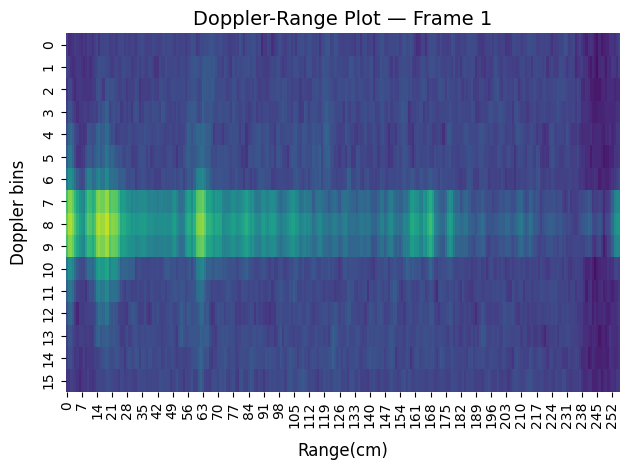

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import pandas as pd
from matplotlib.colors import ListedColormap
import numpy as np
import json
import os

file_name = 'demo1.txt'  # corrected variable name
data = [json.loads(val) for val in open(file_name, "r")]
mmwave_df = pd.DataFrame()

# Create dataframe with the relevant doppler data
for d in data:
    mmwave_df = mmwave_df._append(d['answer'], ignore_index=True)

doppler_global = np.array(mmwave_df['doppz'].tolist())  # ensure 2D list array
min_global = np.min(doppler_global)
max_global = np.max(doppler_global)

# Generate datetime field
datetime_str = data[0]['answer']['datenow'].split("/")[-1] + "-" + str("0") + str(int(data[0]['answer']['datenow'].split("/")[1]) + 1) + "-" + data[0]['answer']['datenow'].split("/")[0]
mmwave_df['datetime'] = mmwave_df['timenow'].apply(lambda e: datetime_str + ' ' + ':'.join(e.split('_')))

# Set up plot
fig, ax = plt.subplots()
frame_counter = [0]

def update(i):
    frame = np.array(doppler_global[i]).astype(np.float32)
    frame = (frame - min_global) / (max_global - min_global + 1e-5)
    ax.clear()
    sns.heatmap(frame, ax=ax, cbar=False, cmap='viridis', vmax=1, vmin=0)
    ax.set_xlabel('Range(cm)', fontsize=12, labelpad=10)
    ax.set_ylabel('Doppler bins', fontsize=12, labelpad=10)
    ax.set_title(f'Doppler-Range Plot — Frame {i + 1}', fontsize=14)
    plt.tight_layout()



# Create and save animation
ani = FuncAnimation(fig, update, frames=range(len(doppler_global)), repeat=False)
file_base = os.path.splitext(file_name)[0]
gif_name = f"{file_base}.gif"
mywriter = animation.PillowWriter(fps=5)
ani.save(gif_name, writer=mywriter)
print(f"Saved animation for {file_name} as {gif_name}")


In [5]:
# Extract x_coord and y_coord from all frames in raw data
x_all = []
y_all = []

for frame in data:
    try:
        answer = frame['answer']
        # If answer is a string, convert it back to dict
        if isinstance(answer, str):
            answer = json.loads(answer)
        x_all.extend(answer['x_coord'])
        y_all.extend(answer['y_coord'])
    except Exception as e:
        print(f"Skipping frame due to error: {e}")


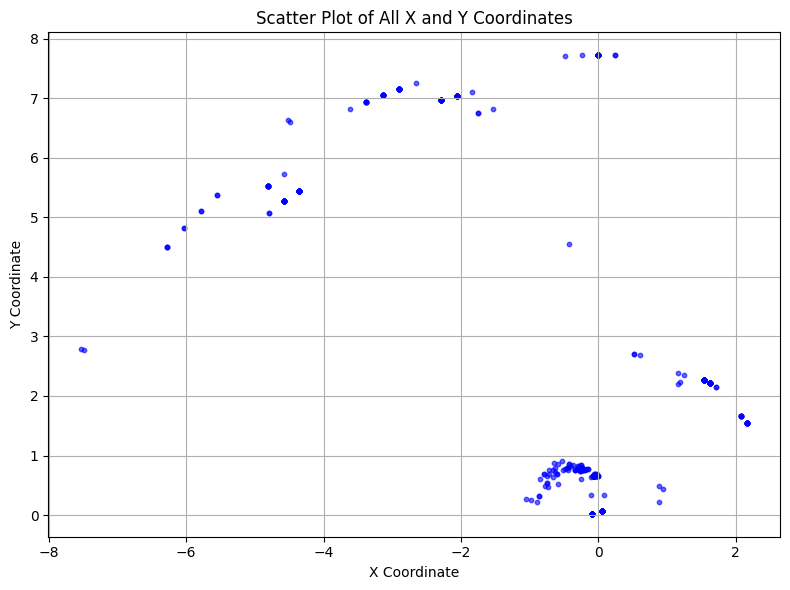

In [7]:
# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_all, y_all, s=10, c='blue', alpha=0.6)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of All X and Y Coordinates')
plt.grid(True)
plt.tight_layout()
plt.savefig("xy_scatter.png", dpi=300)  # High-res image
#plt.show()


In [2]:
import os

# Create output directory
os.makedirs("xy_scatter_frames", exist_ok=True)

# Loop over all frames
for idx, frame in enumerate(data):
    try:
        answer = frame['answer']
        if isinstance(answer, str):
            answer = json.loads(answer)
        
        x_vals = answer['x_coord']
        y_vals = answer['y_coord']

        # Plot for current frame
        plt.figure(figsize=(8, 6))
        plt.scatter(x_vals, y_vals, s=10, c='blue', alpha=0.6)
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(f'Scatter Plot — Frame {idx + 1}')
        plt.grid(True)
        plt.tight_layout()

        # Save image
        fname = f"xy_scatter_frames/frame_{idx + 1:02d}.png"
        plt.savefig(fname, dpi=300)
        plt.close()

    except Exception as e:
        print(f"Skipping frame {idx + 1} due to error: {e}")

print("✅ All scatter plots saved in 'xy_scatter_frames/' folder.")

✅ All scatter plots saved in 'xy_scatter_frames/' folder.


✅ Animated scatter saved as xy_scatter_animation_clean.gif


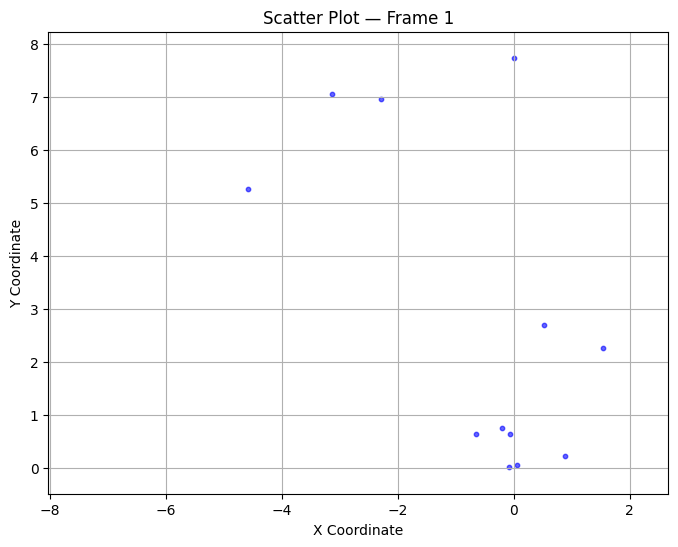

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import json

# Load and parse data
file_name = "demo1.txt"
data = [json.loads(line) for line in open(file_name)]

# Preprocess x and y coordinates
all_coords = []
for frame in data:
    answer = frame["answer"]
    if isinstance(answer, str):
        answer = json.loads(answer)
    x = answer["x_coord"]
    y = answer["y_coord"]
    all_coords.append((x, y))

# Flatten all points to get global limits
x_all = np.concatenate([np.array(x) for x, _ in all_coords])
y_all = np.concatenate([np.array(y) for _, y in all_coords])

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter([], [], s=10, c='blue', alpha=0.6)
x_margin = 0.5
y_margin = 0.5
ax.set_xlim(np.min(x_all) - x_margin, np.max(x_all) + x_margin)
ax.set_ylim(np.min(y_all) - y_margin, np.max(y_all) + y_margin)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True)
title = ax.set_title("Scatter Plot — Frame 1")

# Update function
def update(i):
    x, y = all_coords[i]
    scatter.set_offsets(np.column_stack((x, y)))
    title.set_text(f"Scatter Plot — Frame {i + 1}")

# Create and save animation
ani = FuncAnimation(fig, update, frames=len(all_coords), repeat=False)
ani.save("xy_scatter_animation_clean.gif", writer=PillowWriter(fps=5))
print("✅ Animated scatter saved as xy_scatter_animation_clean.gif")


Using max_index = 2


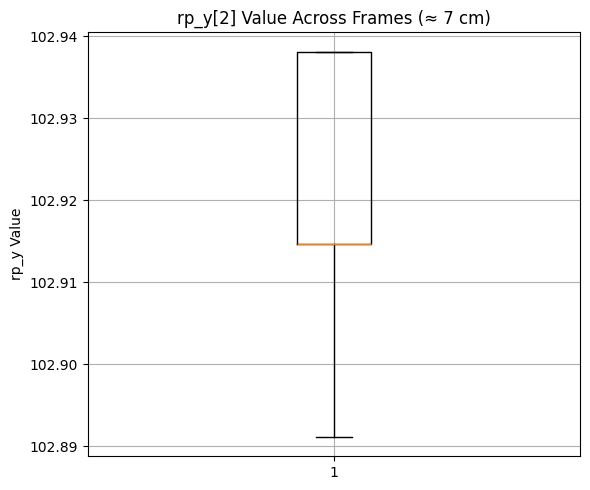

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
filename = 'demo1.txt'
#val_max = float(input("Enter maximum distance in cm: "))   # e.g., 7
val_max = 7

# === Convert distance to index ===
max_index = round(val_max / (100 * 0.044))  # Convert cm to index

print(f"Using max_index = {max_index}")

# === Load JSON file ===
with open(filename, 'r') as f:
    data = [json.loads(line) for line in f]

rp_values = []

for frame in data:
    rp_y = np.array(frame['answer']['rp_y'])
    if max_index < len(rp_y):
        rp_values.append(rp_y[max_index])

# === Plot Box Plot ===
plt.figure(figsize=(6, 5))
plt.boxplot(rp_values, vert=True)
plt.title(f'rp_y[{max_index}] Value Across Frames (≈ {val_max} cm)')
plt.ylabel('rp_y Value')
plt.grid(True)
plt.tight_layout()
plt.show()
